In [ ]:
from google.colab import drive
import os
from pathlib import Path


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dataset_dir = "/content/drive/MyDrive/dataset"
categories = os.listdir(dataset_dir)

print(categories)

['chicken_pox', 'cow_pox', 'healthy', 'HFMD', 'measles', 'monkey_pox']


In [ ]:

IMG_SIZE = (299, 299)
BATCH_SIZE = 32


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

KeyboardInterrupt: 

In [ ]:


def load_and_split_data(dataset_dir):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_dir, category)
        for file in os.listdir(category_path):
            filepaths.append(os.path.join(category_path, file))
            labels.append(label)


    X_train, X_temp, y_train, y_temp = train_test_split(filepaths, labels, test_size=0.3, stratify=labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(dataset_dir)



In [ ]:

# Data Preprocessing
def preprocess_image(file_path):

    image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)

    image = tf.image.resize(image, IMG_SIZE)

    image = image / 255.0
    return image

In [ ]:

def create_generator(filepaths, labels, batch_size=BATCH_SIZE):
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(categories))
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:

train_generator = create_generator(X_train, y_train)
val_generator = create_generator(X_val, y_val)
test_generator = create_generator(X_test, y_test)


In [ ]:

# Load NASNet model without top layers
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:


model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = True

In [ ]:


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 149, 149, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 149, 149, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 149, 149, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 149, 149, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 149, 149, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 153, 153, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 155, 155, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 75, 75, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 75, 75, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 75, 75, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 75, 75, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 75, 75, 11)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 5,358,234 (20.44 MB)

 Trainable params: 5,321,496 (20.30 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7)
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Final-Version-Models-for-Mpox/best_inception_model_v2.keras", save_best_only=True, monitor='val_loss')


In [ ]:


history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.2816 - loss: 1.7359 - val_accuracy: 0.3115 - val_loss: 1.6882 - learning_rate: 1.0000e-05
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 401ms/step - accuracy: 0.6285 - loss: 1.2685 - val_accuracy: 0.3946 - val_loss: 1.5400 - learning_rate: 1.0000e-05
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 396ms/step - accuracy: 0.7434 - loss: 0.9056 - val_accuracy: 0.4751 - val_loss: 1.4038 - learning_rate: 1.0000e-05
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 397ms/step - accuracy: 0.8205 - loss: 0.6405 - val_accuracy: 0.5293 - val_loss: 1.2866 - learning_rate: 1.0000e-05
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 396ms/step - accuracy: 0.8888 - loss: 0.4497 - val_accuracy: 0.5678 - val_loss: 1.1906 - learning_rate: 1.0000e-05
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 396ms/step - accuracy: 0.9339 - loss: 0.3121 - val_accuracy: 0.5984 - val_loss: 1.1127 - learning_rate: 1.0000e-05
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:


test_loss, test_accuracy = model.evaluate(test_generator , steps=len(X_test) // BATCH_SIZE)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 815ms/step - accuracy: 0.9438 - loss: 0.3282
Test Accuracy: 93.38%


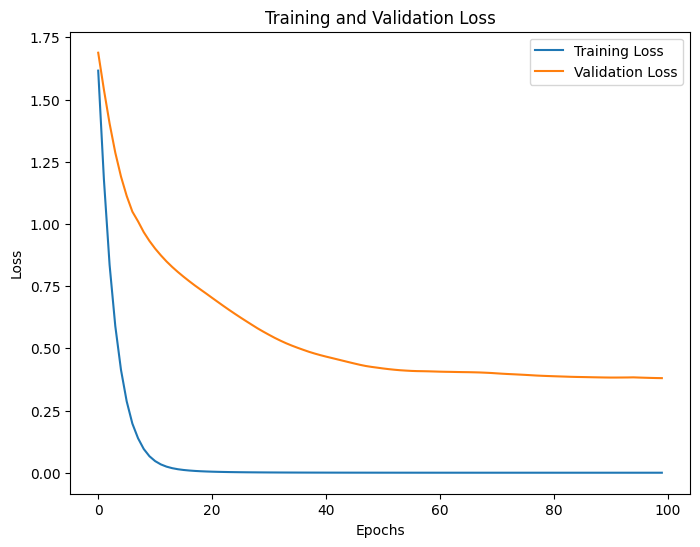

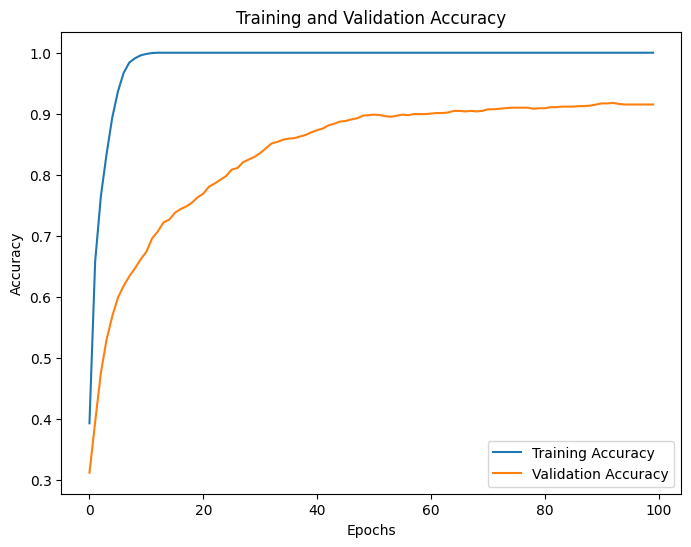

In [ ]:
import matplotlib.pyplot as plt


# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


<Figure size 800x800 with 0 Axes>

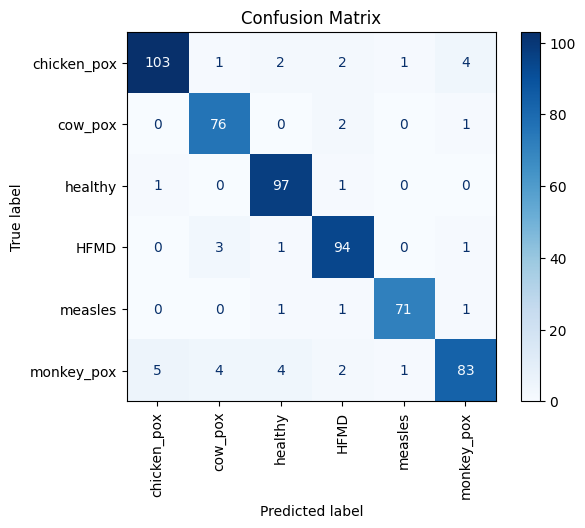

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred = []
y_true = []

for images, labels in test_generator:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))


cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=True)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report


y_pred = []
y_true = []

report = classification_report(y_true, y_pred, target_names=categories)
print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Classification Report:
              precision    recall  f1-score   support

 chicken_pox       0.94      0.91      0.93       113
     cow_pox       0.90      0.96      0.93        79
     healthy       0.92      0.98      0.95        99
        HFMD       0.92      0.95      0.94        99
     measles       0.9